In [182]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
%matplotlib inline
from matplotlib.ticker import ScalarFormatter


## 1. 数据预处理

In [183]:
apple = yf.Ticker("AAPL")
data = apple.history(start='2019-01-01', end='2024-05-06')
# print(type(data))

# print(data.head())
# print(data.columns)
# print(data.index)
# 进行数据预处理

def write_to_csv(data, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    data.to_csv('data/' + filename)
    
write_to_csv(data, 'apple.csv')
        
colume_drop = data.iloc[:, -2:]
# print(colume_drop.head())
data = data.drop(colume_drop, axis=1)
print(data.head())

print(data.tail())

data = data.fillna(method='ffill')
for column in data.columns:
    if data[column].isnull().sum() > 0:
        print(column)
    else:
        print(column, '无缺失值')


                                Open       High        Low      Close  \
Date                                                                    
2019-01-02 00:00:00-05:00  37.118910  38.067913  36.960742  37.845039   
2019-01-03 00:00:00-05:00  34.504368  34.921355  34.029868  34.075401   
2019-01-04 00:00:00-05:00  34.636170  35.599552  34.461229  35.530052   
2019-01-07 00:00:00-05:00  35.635491  35.666646  34.964479  35.450962   
2019-01-08 00:00:00-05:00  35.841593  36.383198  35.592362  36.126774   

                              Volume  
Date                                  
2019-01-02 00:00:00-05:00  148158800  
2019-01-03 00:00:00-05:00  365248800  
2019-01-04 00:00:00-05:00  234428400  
2019-01-07 00:00:00-05:00  219111200  
2019-01-08 00:00:00-05:00  164101200  
                                 Open        High         Low       Close  \
Date                                                                        
2024-04-29 00:00:00-04:00  173.369995  176.029999  173.100006

C:\Users\16972\AppData\Local\Temp\ipykernel_4416\3610407320.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


## 初步对数据进行可视化分析，查看数据的分布情况，以及数据之间的相关性

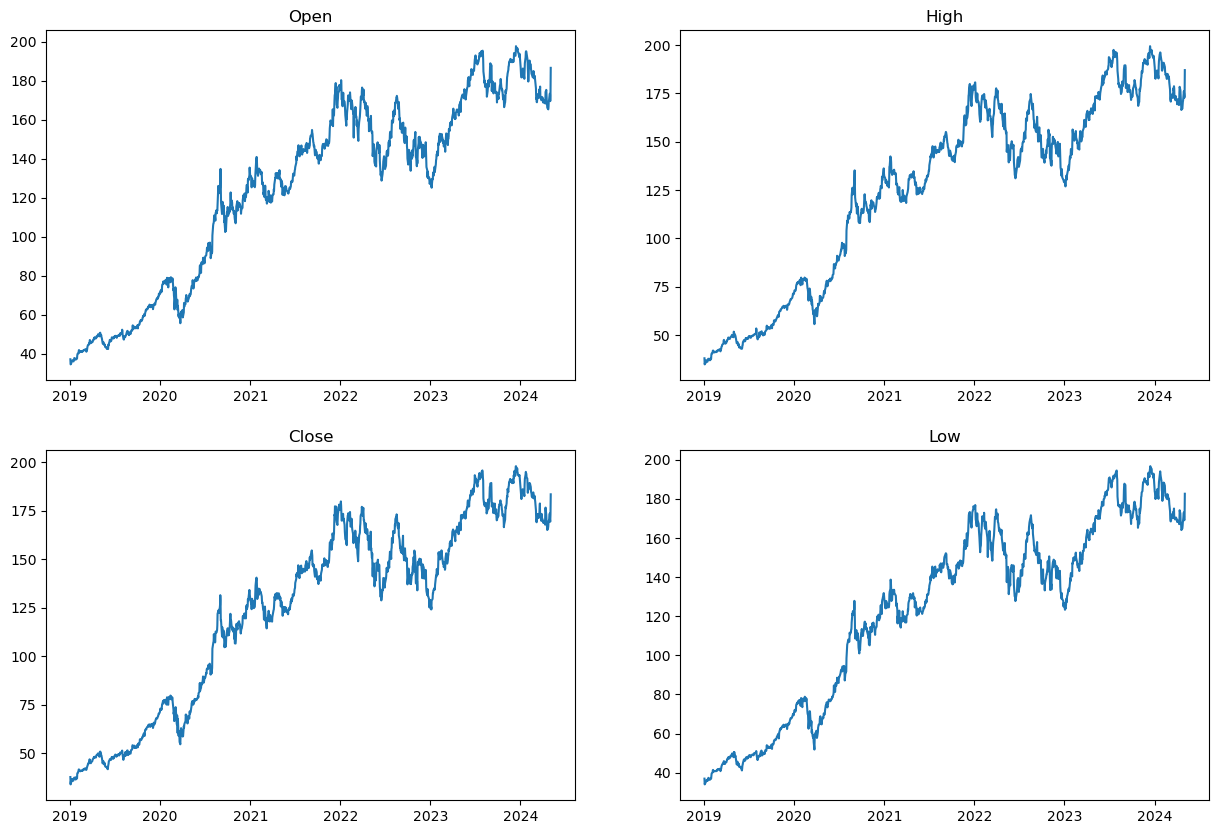

In [184]:
# 画出股票的走势图
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0,0].plot(data['Open'])
ax[0,0].set_title('Open')
ax[0,1].plot(data['High'])
ax[0,1].set_title('High')
ax[1,0].plot(data['Close'])
ax[1,0].set_title('Close')
ax[1,1].plot(data['Low'])
ax[1,1].set_title('Low')
plt.show()

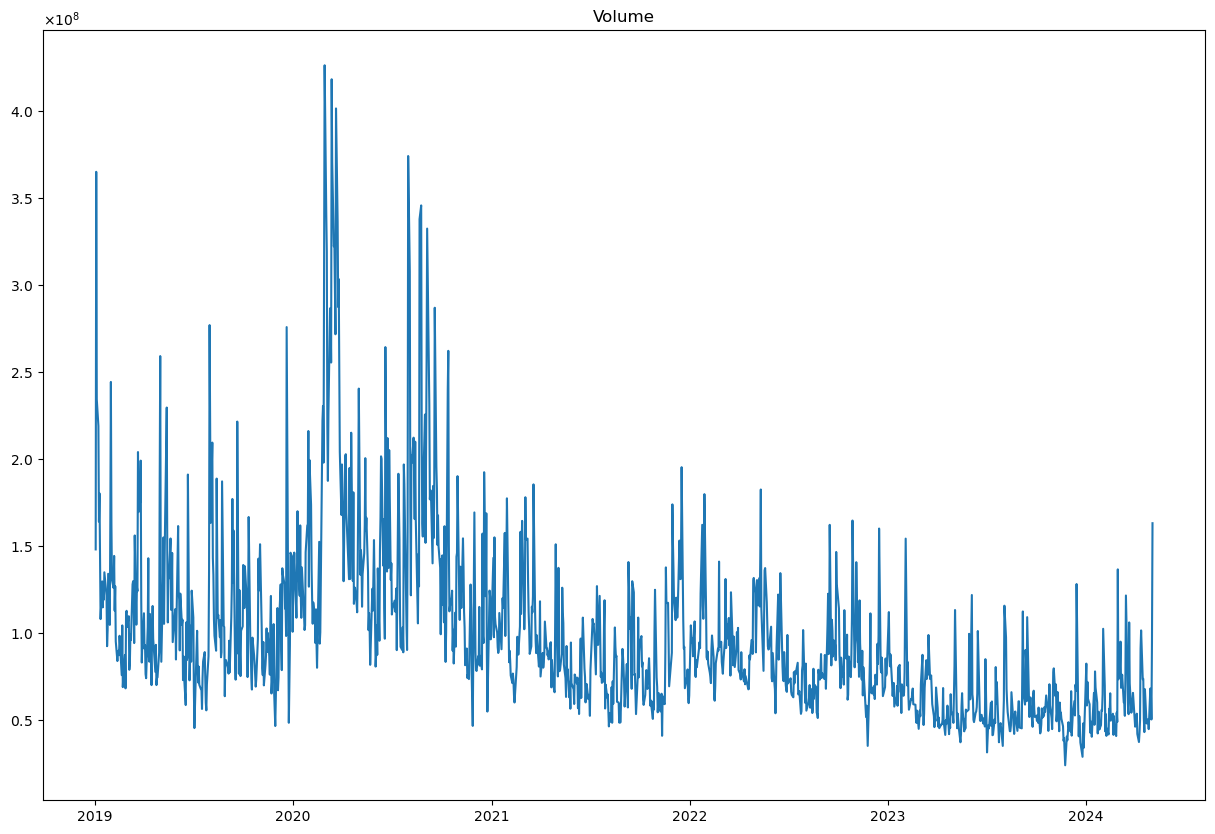

In [185]:
# 画出股票的成交量
plt.figure(figsize=(15, 10))
plt.plot(data['Volume'])
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.title('Volume')
plt.show()

## 使用ARIMA模型进行预测

ADF Statistic: -1.4306477405042295
p-value: 0.5674982443737804
Critical Values: {'1%': -3.43522851297339, '5%': -2.8636944861078013, '10%': -2.5679170525584523}
不平稳
ADF Statistic: -37.38424714026073
p-value: 0.0


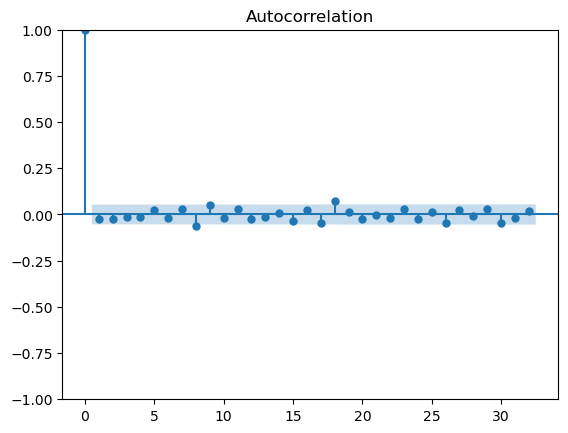

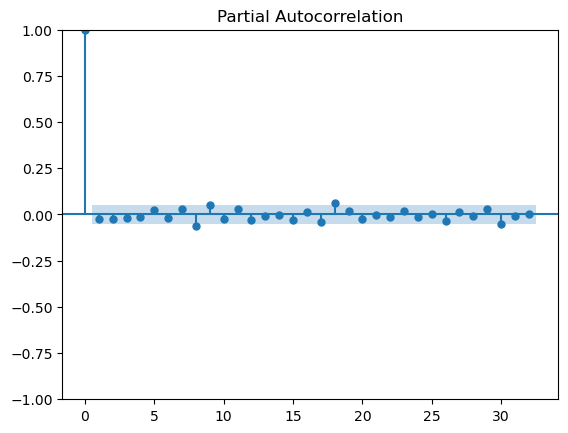

In [186]:
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
close_price = data['Close']
open_price = data['Open']
volume = data['Volume']

# 进行ADF检验
result = adfuller(close_price)
ADF_statistic = result[0]
p_value = result[1]
critical_values = result[4]
print('ADF Statistic:', ADF_statistic)
print('p-value:', p_value)
print('Critical Values:', critical_values)

if p_value < 0.05:
    print('平稳')
    plot_acf(close_price)
    plot_pacf(close_price)
else:
    print('不平稳')
    diff_close_price = close_price.diff().dropna()
    diff_result = adfuller(diff_close_price)
    diff_ADF_statistic = diff_result[0]
    diff_p_value = diff_result[1]
    print('ADF Statistic:', diff_ADF_statistic)
    print('p-value:', diff_p_value)
    plot_acf(diff_close_price)
    # 绘制ACF和PACF图
    plot_pacf(diff_close_price)
    







## 进行ARIMA模型预测

In [187]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm



# 将数据分为训练集和测试集
train = close_price[:'2023-01-01']
test = close_price['2023-01-01':]




## 进行模型评估

C:\Users\16972\AppData\Local\Temp\ipykernel_4416\1687539210.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


Test RMSE: 2.304


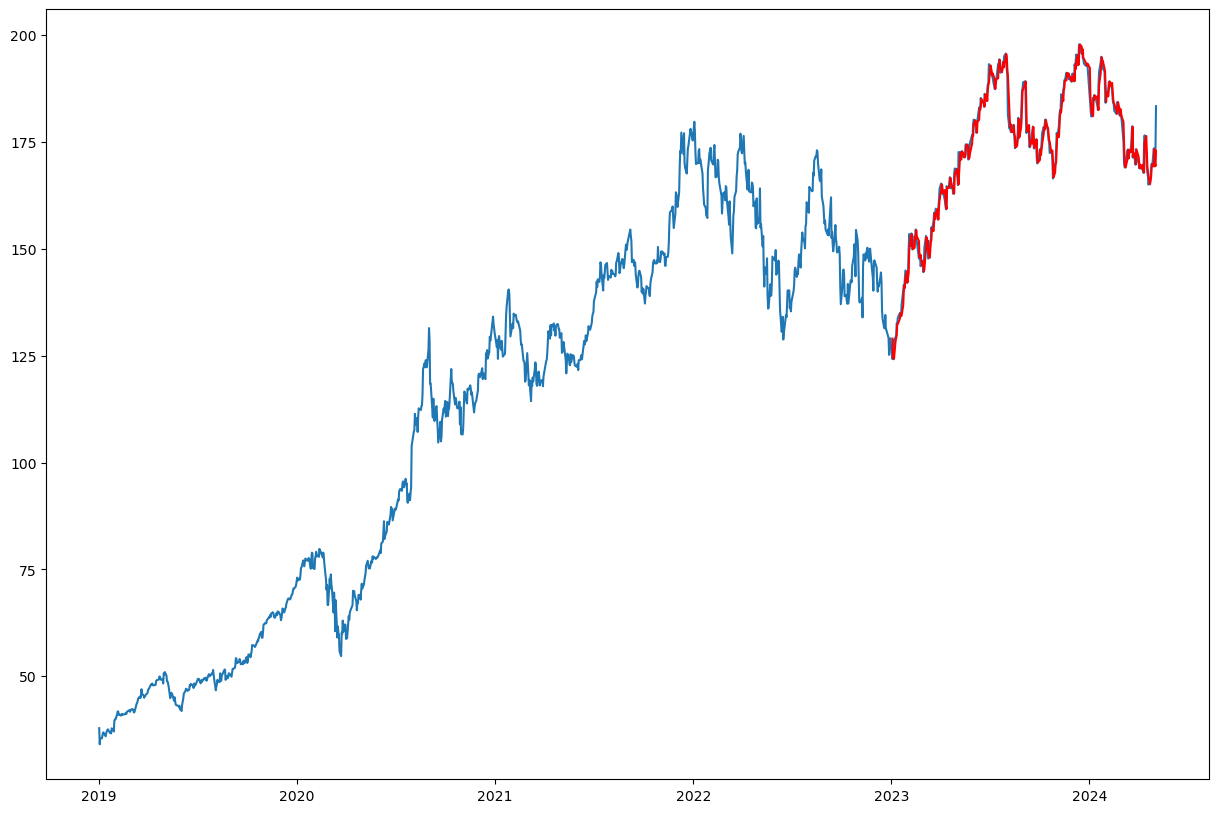

In [191]:
# 进行预测
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1)).fit()
    output = model.forecast()
    output = output.tolist()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
    
    
# 计算RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

    
# 画出预测结果
plt.figure(figsize=(15, 10))
predict_result = pd.Series(predictions, index=test.index)
plt.plot(close_price)
plt.plot(predict_result, color='red')


e:\applist\miniconda\envs\sklearn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\applist\miniconda\envs\sklearn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\applist\miniconda\envs\sklearn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC: 6149.854701653648
BIC: 6165.4626852432175
[183.02329639764505, 182.8339113161348, 182.73336223869467, 182.67997832432593, 182.65163552510904, 182.63658765391136, 182.62859837854555, 182.6243566808308, 182.62210466188296, 182.62090901106518, 182.62027421139823, 182.61993718104523, 182.6197582435556, 182.619663241355, 182.61961280241044, 182.61958602316628, 182.6195718054239, 182.61956425688382, 182.61956024918302, 182.61955812139865, 182.61955699170696, 182.61955639192655, 182.61955607348878, 182.61955590442253, 182.6195558146612, 182.61955576700475, 182.6195557417028, 182.6195557282694, 182.6195557211373, 182.61955571735066, 182.61955571534025, 182.61955571427288, 182.61955571370618, 182.6195557134053, 182.61955571324557, 182.61955571316076, 182.61955571311574, 182.61955571309184, 182.61955571307914, 182.6195557130724, 182.61955571306882, 182.61955571306692, 182.61955571306592, 182.61955571306538, 182.6195557130651, 182.61955571306495, 182.61955571306487, 182.61955571306484, 182.6

e:\applist\miniconda\envs\sklearn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\applist\miniconda\envs\sklearn\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


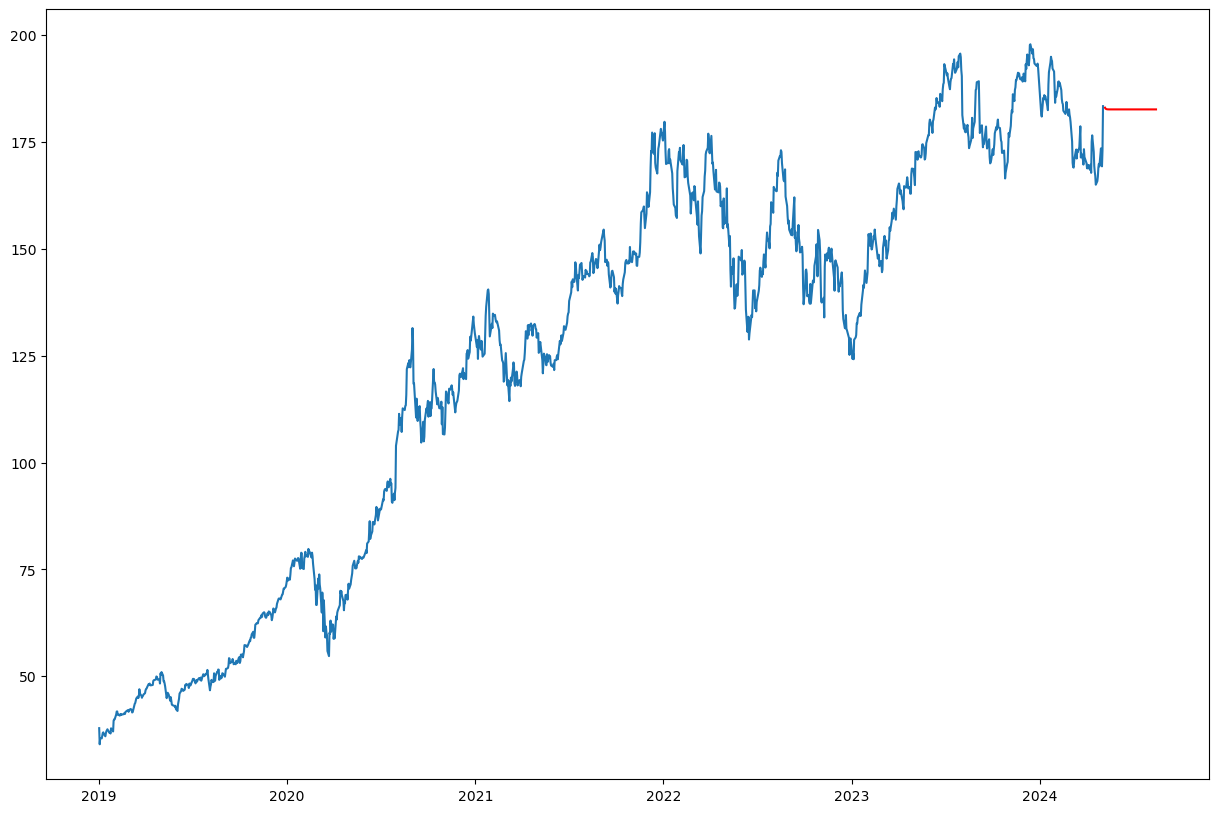

In [200]:

model = ARIMA(close_price, order=(1,1,1)).fit()


# 进行AIC 和 BIC的评估
print('AIC:', model.aic)
print('BIC:', model.bic)
# 残差分析
residuals = model.resid

# fig = plt.figure(figsize=(15, 10))
# plt.plot(residuals)
# plt.title('Residuals')
# plt.show()

# # 画出残差的密度图
# fig = plt.figure(figsize=(15, 10))
# sns.kdeplot(residuals)
# plt.title('Residuals Density')
# plt.show()

# residual_pd = pd.DataFrame(residuals)
# print(residual_pd.describe())

future_price = model.forecast(steps=100)
future_price = future_price.tolist()
print(future_price)
future_index = pd.date_range('2024-05-07', periods=100)
future_price = pd.Series(future_price, index=future_index)
plt.figure(figsize=(15, 10))
plt.plot(close_price)
plt.plot(future_price, color='red')
plt.show()